In [1]:
%cd ..

s:\Sasha\project\HSE\MMM_project


In [2]:
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN

import pandas as pd

## Load data

In [3]:
P0_data = pd.read_csv("./data/geoplant-at-paiss/GLC25_P0_metadata_train.csv")

# Group by survey_id (place speciesId in list)
columns = P0_data.columns.tolist()
columns.remove("speciesId")
columns.remove("surveyId")

aggregations = {col: "first" for col in columns}
aggregations["speciesId"] = lambda x: x.tolist()

P0_data = P0_data.groupby("surveyId").agg(aggregations).reset_index()

P0_data = P0_data[["lat","lon","speciesId"]]
P0_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3845533 entries, 0 to 3845532
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   lat        float64
 1   lon        float64
 2   speciesId  object 
dtypes: float64(2), object(1)
memory usage: 88.0+ MB


In [4]:
PA_data = pd.read_csv("./data/geoplant-at-paiss/GLC25_PA_metadata_train.csv")

# Group by survey_id (place speciesId in list)
columns = PA_data.columns.tolist()
columns.remove("speciesId")
columns.remove("surveyId")

aggregations = {col: "first" for col in columns}
aggregations["speciesId"] = lambda x: -1 # We don't need species, we only need this point to match PO and PA points

PA_data = PA_data.groupby("surveyId").agg(aggregations).reset_index()

PA_data = PA_data[["lat","lon","speciesId"]]
PA_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88987 entries, 0 to 88986
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lat        88987 non-null  float64
 1   lon        88987 non-null  float64
 2   speciesId  88987 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.0 MB


In [5]:
all_data = pd.concat([P0_data, PA_data]).reset_index(drop=True)
all_data.head()

,lat,lon,speciesId
0,43.74605,1.573057,[3383.0]
1,42.12559,0.314948,[1152.0]
2,48.29520,-0.934518,[6772.0]
3,53.63367,-2.644535,[3318.0]
4,49.79471,7.925086,[3374.0]


In [6]:
all_data["lon"] = all_data["lon"] * (1 - all_data["lat"] / 90) # As we closer to poles, the longitude distance is smaller
all_data["lon"] = all_data["lon"] * 111700 # Convert degrees to meters
all_data["lat"] = all_data["lat"] * 111700 # Convert degrees to meters

## Make 2d clusterization

In [11]:
clustering = DBSCAN(eps=100, min_samples=1).fit(all_data[["lat","lon"]]) # eps is taken by reclustering only on PA (this is the highest value to make all surveys separated)
all_data["cluster"] = clustering.labels_
P0_data = all_data[all_data["speciesId"].apply(lambda x: isinstance(x, list))].reset_index(drop=True)
PA_data = all_data[all_data["speciesId"] == -1].reset_index(drop=True)

## visualize clusters

In [12]:
print(f"Number of clusters found: {len(set(P0_data['cluster']))} of {len(P0_data)} P0 points")
print(f"Number of clusters found: {len(set(PA_data['cluster']))} of {len(PA_data)} PA points")

Number of clusters found: 1799948 of 3845533 P0 points
Number of clusters found: 51795 of 88987 PA points


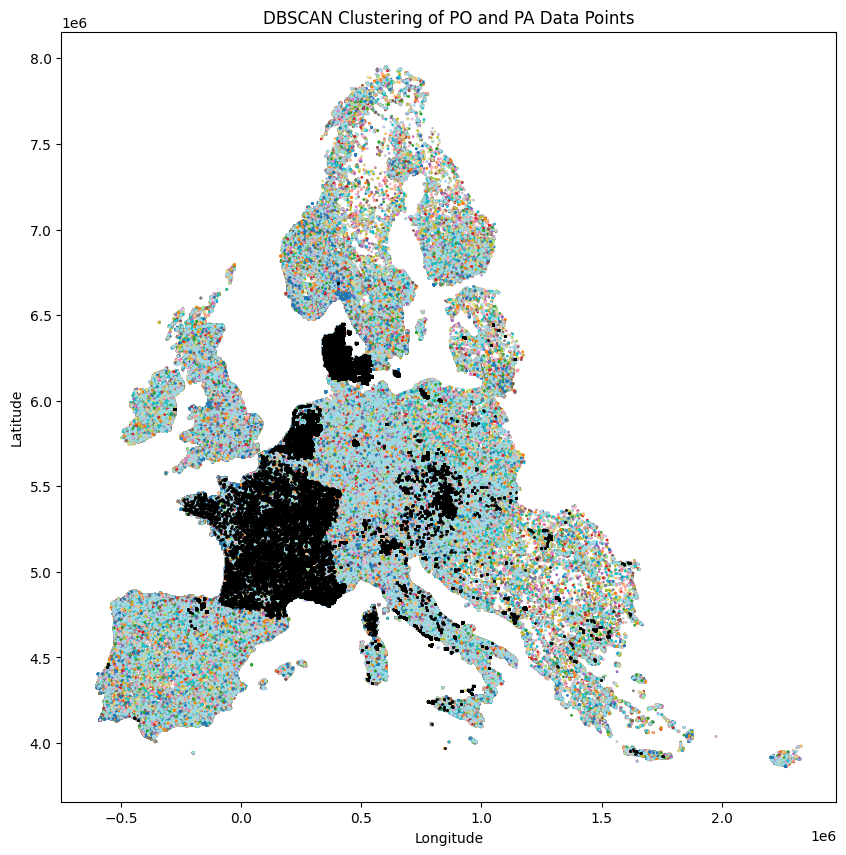

In [13]:
plt.figure(figsize=(10,10))
plt.scatter(P0_data["lon"], P0_data["lat"], c=P0_data["cluster"], cmap="tab20", s=1)
plt.scatter(PA_data["lon"], PA_data["lat"], c="black", s=1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clustering of PO and PA Data Points")
plt.show()